In [ ]:
%pip install pandas numpy seaborn matplotlib scikit-learn xgboost catboost

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
import pickle as pkl


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler as Scaler
from sklearn.preprocessing import StandardScaler as StdScaler

from models import decision_tree, k_nearest, logistic_regression, random_forest, support_vector_cls, xgboost
# from catboost import CatBoostClassifier

In [2]:
csv_file_names = ["pyradiomics_extraction_box_with_correct_mask.csv", "pyradiomics_extraction_box_without_correct_mask.csv", 
             "pyradiomics_extraction_segmentation_maskcorrect.csv", "pyradiomics_extraction_segmentation_no_maskcorrect.csv"]

FILE_INDEX = 2
CLASS_LABELS = '../../Data/Patient class labels.csv'
DF_PATH = '../../Data/Without Demographic Features/' + csv_file_names[FILE_INDEX]

FILENAME = csv_file_names[FILE_INDEX].split('.')[0] +  '_with_preprocessing'
RESULTS_PATH = f'Results_DemoGraphics/{FILENAME}.csv'
MODEL_PICKLING = f'Results_DemoGraphics/{FILENAME}.pkl'

In [31]:
TRAIN_RATIO = 0.5
VAL_RATIO = 0.2
TEST_RATIO = 0.3

SEED = 2454259

CRITERION = 'accuracy'

In [4]:
labels = pd.read_csv(CLASS_LABELS)
features = pd.read_csv(DF_PATH).drop(columns = 'sequence', errors='ignore')
total_features = pd.merge(features, labels, left_on = 'patient', right_on = 'Patient ID').drop(columns = ['Patient ID', 'patient'])
total_features

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,ER,PR,HER2,Mol Subtype
0,0.807005,0.729780,23.614309,32.358102,36.073737,38.431136,39.309346,45.798426,11352.720347,26.113156,...,4.009263e+06,0.0,1000000.0,0.0,0.0,0.0,0,0,1,2
1,0.641558,0.577887,17.378564,30.072592,23.148662,29.852205,29.748492,33.784677,4051.005400,19.293327,...,6.054147e+06,0.0,1000000.0,0.0,0.0,0.0,0,0,0,3
2,0.756223,0.272616,13.050754,47.872295,40.488107,43.126056,56.606869,57.665740,11866.396187,36.202150,...,1.663605e+07,0.0,1000000.0,0.0,0.0,0.0,1,1,0,0
3,0.718139,0.610317,8.730117,14.304230,11.420813,14.972284,14.477716,16.540987,829.333325,10.272429,...,0.000000e+00,0.0,1000000.0,0.0,0.0,0.0,1,1,0,0
4,0.687760,0.436019,22.539193,51.693090,55.175581,49.674566,36.443449,58.274413,25572.814941,35.552459,...,4.436710e+08,0.0,1000000.0,0.0,0.0,0.0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,0.886914,0.668151,28.553043,42.734408,45.886501,41.977361,51.383808,56.016573,28567.316541,37.901723,...,0.000000e+00,0.0,1000000.0,0.0,0.0,0.0,1,1,0,0
918,0.757419,0.596730,12.864613,21.558522,21.066007,20.543932,25.375225,27.268354,2558.161146,16.328835,...,4.485585e+06,0.0,1000000.0,0.0,0.0,0.0,1,1,0,0
919,0.872632,0.837806,15.199560,18.142097,19.038279,20.649190,20.505122,24.348411,2671.696974,15.831368,...,0.000000e+00,0.0,1000000.0,0.0,0.0,0.0,1,1,0,0
920,0.855874,0.735409,30.453436,41.410193,43.076382,45.448460,48.143552,54.398662,28568.303573,35.441921,...,1.504081e+08,0.0,1000000.0,0.0,0.0,0.0,1,1,0,0


## Train test split

In [5]:
def train_test_val_splits(df, train_ratio = 0.8, val_ratio = 0.2, random_state = 2454259):
   
    val_ratio_adj = val_ratio / (1-train_ratio)

    train_df, val_df = train_test_split(df, train_size = train_ratio, random_state= random_state)
    val_df, test_df = train_test_split(val_df, train_size = val_ratio_adj, random_state= random_state)

    return train_df, val_df, test_df

train_df, val_df, test_df = train_test_val_splits(total_features, TRAIN_RATIO, VAL_RATIO, random_state = SEED)
train_df.shape, val_df.shape, test_df.shape

((461, 111), (184, 111), (277, 111))

Feature scaling - on all three datasets;    
Feature Engineering - on training+validation only;      
Resampling - on training only

In [17]:
# read csv file present in ../Train Test Splits/ER or HER2 or PR or Mol Subtype/test or train.csv
train_x_er = pd.read_csv('../../Train Test Splits/ER/train.csv')
train_y_er = train_x_er[train_x_er.columns[-1]]
train_x_er = train_x_er.drop(columns = train_x_er.columns[-1])

train_x_pr = pd.read_csv('../../Train Test Splits/PR/train.csv')
train_y_pr = train_x_pr[train_x_pr.columns[-1]]
train_x_pr = train_x_pr.drop(columns = train_x_pr.columns[-1])

train_x_her2 = pd.read_csv('../../Train Test Splits/HER2/train.csv')
train_y_her2 = train_x_her2[train_x_her2.columns[-1]]
train_x_her2 = train_x_her2.drop(columns = train_x_her2.columns[-1])

train_x_mol_subtype = pd.read_csv('../../Train Test Splits/Mol_Subtype/train.csv')
train_y_mol_subtype = train_x_mol_subtype[train_x_mol_subtype.columns[-1]]
train_x_mol_subtype = train_x_mol_subtype.drop(columns = train_x_mol_subtype.columns[-1])

# Test Data
test_x_er = pd.read_csv('../../Train Test Splits/ER/test.csv')
test_y_er = test_x_er[test_x_er.columns[-1]]
test_x_er = test_x_er.drop(columns = test_x_er.columns[-1])

test_x_pr = pd.read_csv('../../Train Test Splits/PR/test.csv')
test_y_pr = test_x_pr[test_x_pr.columns[-1]]
test_x_pr = test_x_pr.drop(columns = test_x_pr.columns[-1])

test_x_her2 = pd.read_csv('../../Train Test Splits/HER2/test.csv')
test_y_her2 = test_x_her2[test_x_her2.columns[-1]]
test_x_her2 = test_x_her2.drop(columns = test_x_her2.columns[-1])

test_x_mol_subtype = pd.read_csv('../../Train Test Splits/Mol_Subtype/test.csv')
test_y_mol_subtype = test_x_mol_subtype[test_x_mol_subtype.columns[-1]]
test_x_mol_subtype = test_x_mol_subtype.drop(columns = test_x_mol_subtype.columns[-1])

In [74]:
# train_x = train_df.drop(columns = ['ER', 'PR', 'HER2', 'Mol Subtype'])
# train_y_er = train_df['ER'].to_numpy()
# train_y_pr = train_df['PR'].to_numpy()
# train_y_her2 = train_df['HER2'].to_numpy()
# train_y_mol_subtype = train_df['Mol Subtype'].to_numpy()


# val_x = val_df.drop(columns = ['ER', 'PR', 'HER2', 'Mol Subtype'])
# val_y_er = val_df['ER'].to_numpy()
# val_y_pr = val_df['PR'].to_numpy()
# val_y_her2 = val_df['HER2'].to_numpy()
# val_y_mol_subtype = val_df['Mol Subtype'].to_numpy()


# test_x = test_df.drop(columns = ['ER', 'PR', 'HER2', 'Mol Subtype'])
# test_y_er = test_df['ER'].to_numpy()
# test_y_pr = test_df['PR'].to_numpy()
# test_y_her2 = test_df['HER2'].to_numpy()
# test_y_mol_subtype = test_df['Mol Subtype'].to_numpy()


# # scaler = Scaler()
# # scaler.fit(train_x)
# # train_x = scaler.transform(train_x)
# # val_x = scaler.transform(val_x)
# # test_x = scaler.transform(test_x)
# # print('Features scaled')

In [9]:
# train_x_er, train_x_pr, train_x_her2, train_x_mol_subtype = train_x.copy(), train_x.copy(), train_x.copy(), train_x.copy()
# val_x_er, val_x_pr, val_x_her2, val_x_mol_subtype = val_x.copy(), val_x.copy(), val_x.copy(), val_x.copy()
# test_x_er, test_x_pr, test_x_her2, test_x_mol_subtype = test_x.copy(), test_x.copy(), test_x.copy(), test_x.copy()

## Resampling

### Imbalanced Data

In [6]:
# splitting the dataset for training, testing, validating on ER subtype
train_x_er, train_y_er = train_df.drop(columns = ['ER']), train_df['ER']
val_x_er, val_y_er = val_df.drop(columns = ['ER']), val_df['ER']
test_x_er, test_y_er = test_df.drop(columns = ['ER']), test_df['ER']

# splitting the dataset for training, testing, validating on PR subtyp
train_x_pr, train_y_pr = train_df.drop(columns = ['PR']), train_df['PR']
val_x_pr, val_y_pr = val_df.drop(columns = ['PR']), val_df['PR']
test_x_pr, test_y_pr = test_df.drop(columns = ['PR']), test_df['PR']

# splitting the dataset for training, testing, validating on HER2 subtype
train_x_her2, train_y_her2 = train_df.drop(columns = ['HER2']), train_df['HER2']
val_x_her2, val_y_her2 = val_df.drop(columns = ['HER2']), val_df['HER2']
test_x_her2, test_y_her2 = test_df.drop(columns = ['HER2']), test_df['HER2']

# splitting the dataset for training, testing, validating on molecular subtype
train_x_mol_subtype, train_y_mol_subtype = train_df.drop(columns = ['Mol Subtype']), train_df['Mol Subtype']
val_x_mol_subtype, val_y_mol_subtype = val_df.drop(columns = ['Mol Subtype']), val_df['Mol Subtype']
test_x_mol_subtype, test_y_mol_subtype = test_df.drop(columns = ['Mol Subtype']), test_df['Mol Subtype']

### Scaling the features

In [19]:
# scaler = Scaler()
# train_x_er_scaled = pd.DataFrame(scaler.fit_transform(train_x_er.drop(columns = ['PR', 'HER2', 'Mol Subtype'])), columns=train_x_er.columns[:-3])
# train_x_er_scaled['PR'] = [i for i in train_x_er['PR']]
# train_x_er_scaled['HER2'] = [i for i in train_x_er['HER2']]
# train_x_er_scaled['Mol Subtype'] = [i for i in train_x_er['Mol Subtype']]
# train_x_er = train_x_er_scaled

# val_x_er_scaled = scaler.transform(val_x_er.drop(columns = ['PR', 'HER2', 'Mol Subtype']))
# val_x_er_scaled = pd.DataFrame(val_x_er_scaled, columns = val_x_er.columns[:-3])
# val_x_er_scaled['PR'] = [i for i in val_x_er['PR']]
# val_x_er_scaled['HER2'] = [i for i in val_x_er['HER2']]
# val_x_er_scaled['Mol Subtype'] = [i for i in val_x_er['Mol Subtype']]
# val_x_er = val_x_er_scaled

# test_x_er_scaled = scaler.transform(test_x_er.drop(columns = ['PR', 'HER2', 'Mol Subtype']))
# test_x_er_scaled = pd.DataFrame(test_x_er_scaled, columns = test_x_er.columns[:-3])
# test_x_er_scaled['PR'] = [i for i in test_x_er['PR']]
# test_x_er_scaled['HER2'] = [i for i in test_x_er['HER2']]
# test_x_er_scaled['Mol Subtype'] = [i for i in test_x_er['Mol Subtype']]
# test_x_er = test_x_er_scaled


# scaler = Scaler()
# train_x_pr_scaled = pd.DataFrame(scaler.fit_transform(train_x_pr.drop(columns = ['ER', 'HER2', 'Mol Subtype'])), columns=train_x_pr.columns[:-3])
# train_x_pr_scaled['ER'] = [i for i in train_x_pr['ER']]
# train_x_pr_scaled['HER2'] = [i for i in train_x_pr['HER2']]
# train_x_pr_scaled['Mol Subtype'] = [i for i in train_x_pr['Mol Subtype']]
# train_x_pr = train_x_pr_scaled

# val_x_pr_scaled = scaler.transform(val_x_pr.drop(columns = ['ER', 'HER2', 'Mol Subtype']))
# val_x_pr_scaled = pd.DataFrame(val_x_pr_scaled, columns = val_x_pr.columns[:-3])
# val_x_pr_scaled['ER'] = [i for i in val_x_pr['ER']]
# val_x_pr_scaled['HER2'] = [i for i in val_x_pr['HER2']]
# val_x_pr_scaled['Mol Subtype'] = [i for i in val_x_pr['Mol Subtype']]
# val_x_pr = val_x_pr_scaled

# test_x_pr_scaled = scaler.transform(test_x_pr.drop(columns = ['ER', 'HER2', 'Mol Subtype']))
# test_x_pr_scaled = pd.DataFrame(test_x_pr_scaled, columns = test_x_pr.columns[:-3])
# test_x_pr_scaled['ER'] = [i for i in test_x_pr['ER']]
# test_x_pr_scaled['HER2'] = [i for i in test_x_pr['HER2']]
# test_x_pr_scaled['Mol Subtype'] = [i for i in test_x_pr['Mol Subtype']]
# test_x_pr = test_x_pr_scaled


# scaler = Scaler()
# train_x_her2_scaled = pd.DataFrame(scaler.fit_transform(train_x_her2.drop(columns = ['PR', 'ER', 'Mol Subtype'])), columns=train_x_her2.columns[:-3])
# train_x_her2_scaled['PR'] = [i for i in train_x_her2['PR']]
# train_x_her2_scaled['ER'] = [i for i in train_x_her2['ER']]
# train_x_her2_scaled['Mol Subtype'] = [i for i in train_x_her2['Mol Subtype']]
# train_x_her2 = train_x_her2_scaled

# val_x_her2_scaled = scaler.transform(val_x_her2.drop(columns = ['PR', 'ER', 'Mol Subtype']))
# val_x_her2_scaled = pd.DataFrame(val_x_her2_scaled, columns = val_x_her2.columns[:-3])
# val_x_her2_scaled['PR'] = [i for i in val_x_her2['PR']]
# val_x_her2_scaled['ER'] = [i for i in val_x_her2['ER']]
# val_x_her2_scaled['Mol Subtype'] = [i for i in val_x_her2['Mol Subtype']]
# val_x_her2 = val_x_her2_scaled

# test_x_her2_scaled = scaler.transform(test_x_her2.drop(columns = ['PR', 'ER', 'Mol Subtype']))
# test_x_her2_scaled = pd.DataFrame(test_x_her2_scaled, columns = test_x_her2.columns[:-3])
# test_x_her2_scaled['PR'] = [i for i in test_x_her2['PR']]
# test_x_her2_scaled['ER'] = [i for i in test_x_her2['ER']]
# test_x_her2_scaled['Mol Subtype'] = [i for i in test_x_her2['Mol Subtype']]
# test_x_her2 = test_x_her2_scaled


# scaler = Scaler()
# train_x_mol_subtype_scaled = pd.DataFrame(scaler.fit_transform(train_x_mol_subtype.drop(columns = ['PR', 'HER2', 'ER'])), columns=train_x_mol_subtype.columns[:-3])
# train_x_mol_subtype_scaled['PR'] = [i for i in train_x_mol_subtype['PR']]
# train_x_mol_subtype_scaled['HER2'] = [i for i in train_x_mol_subtype['HER2']]
# train_x_mol_subtype_scaled['ER'] = [i for i in train_x_mol_subtype['ER']]
# train_x_mol_subtype = train_x_mol_subtype_scaled

# val_x_mol_subtype_scaled = scaler.transform(val_x_mol_subtype.drop(columns = ['PR', 'HER2', 'ER']))
# val_x_mol_subtype_scaled = pd.DataFrame(val_x_mol_subtype_scaled, columns=val_x_mol_subtype.columns[:-3])
# val_x_mol_subtype_scaled['PR'] = [i for i in val_x_mol_subtype['PR']]
# val_x_mol_subtype_scaled['HER2'] = [i for i in val_x_mol_subtype['HER2']]
# val_x_mol_subtype_scaled['ER'] = [i for i in val_x_mol_subtype['ER']]
# val_x_mol_subtype = val_x_mol_subtype_scaled

# test_x_mol_subtype_scaled = scaler.transform(test_x_mol_subtype.drop(columns = ['PR', 'HER2', 'ER']))
# test_x_mol_subtype_scaled = pd.DataFrame(test_x_mol_subtype_scaled, columns = test_x_mol_subtype.columns[:-3])
# test_x_mol_subtype_scaled['PR'] = [i for i in test_x_mol_subtype['PR']]
# test_x_mol_subtype_scaled['HER2'] = [i for i in test_x_mol_subtype['HER2']]
# test_x_mol_subtype_scaled['ER'] = [i for i in test_x_mol_subtype['ER']]
# test_x_mol_subtype = test_x_mol_subtype_scaled


,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,PR,HER2,ER
0,0.604399,0.564594,0.079942,0.065472,0.084673,0.069081,0.043407,0.056009,0.001362,0.070515,...,0.229344,0.000027,0.0,1.0,0.0,0.0,0.0,0,0,1
1,0.823788,0.846555,0.137264,0.081076,0.100218,0.084731,0.084491,0.085526,0.004307,0.109267,...,0.011370,0.001314,0.0,1.0,0.0,0.0,0.0,0,0,0
2,0.772297,0.798412,0.090522,0.044050,0.067501,0.047096,0.039988,0.042446,0.001303,0.061568,...,0.029758,0.000000,0.0,1.0,0.0,0.0,0.0,1,1,1
3,0.553892,0.624132,0.095531,0.074181,0.067646,0.070819,0.076371,0.067525,0.002086,0.074157,...,0.030295,0.000191,0.0,1.0,0.0,0.0,0.0,1,0,1
4,0.746826,0.751363,0.277834,0.238722,0.250454,0.244521,0.258512,0.250180,0.041687,0.277588,...,0.041008,0.005425,0.0,1.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,0.837545,0.634051,0.119385,0.100927,0.121829,0.087610,0.111706,0.101763,0.004885,0.134487,...,0.006712,0.000000,0.0,1.0,0.0,0.0,0.0,1,0,1
181,0.624597,0.681265,0.171663,0.149283,0.179476,0.139665,0.161001,0.156275,0.009885,0.157395,...,0.015051,0.002277,0.0,1.0,0.0,0.0,0.0,1,1,1
182,0.951077,0.966676,0.063751,0.008038,0.031717,0.011524,0.014279,0.011155,0.000328,0.028159,...,0.103296,0.000000,0.0,1.0,0.0,0.0,0.0,0,0,0
183,0.731133,0.437321,0.134020,0.190648,0.152115,0.153424,0.187266,0.165633,0.014013,0.220641,...,0.008806,0.000000,0.0,1.0,0.0,0.0,0.0,0,1,0


In [20]:
# count unique values in original_ngtdm_Strength
test_x_mol_subtype

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,PR,HER2,ER
0,0.604399,0.564594,0.079942,0.065472,0.084673,0.069081,0.043407,0.056009,0.001362,0.070515,...,0.229344,0.000027,0.0,1.0,0.0,0.0,0.0,0,0,1
1,0.823788,0.846555,0.137264,0.081076,0.100218,0.084731,0.084491,0.085526,0.004307,0.109267,...,0.011370,0.001314,0.0,1.0,0.0,0.0,0.0,0,0,0
2,0.772297,0.798412,0.090522,0.044050,0.067501,0.047096,0.039988,0.042446,0.001303,0.061568,...,0.029758,0.000000,0.0,1.0,0.0,0.0,0.0,1,1,1
3,0.553892,0.624132,0.095531,0.074181,0.067646,0.070819,0.076371,0.067525,0.002086,0.074157,...,0.030295,0.000191,0.0,1.0,0.0,0.0,0.0,1,0,1
4,0.746826,0.751363,0.277834,0.238722,0.250454,0.244521,0.258512,0.250180,0.041687,0.277588,...,0.041008,0.005425,0.0,1.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,0.837545,0.634051,0.119385,0.100927,0.121829,0.087610,0.111706,0.101763,0.004885,0.134487,...,0.006712,0.000000,0.0,1.0,0.0,0.0,0.0,1,0,1
181,0.624597,0.681265,0.171663,0.149283,0.179476,0.139665,0.161001,0.156275,0.009885,0.157395,...,0.015051,0.002277,0.0,1.0,0.0,0.0,0.0,1,1,1
182,0.951077,0.966676,0.063751,0.008038,0.031717,0.011524,0.014279,0.011155,0.000328,0.028159,...,0.103296,0.000000,0.0,1.0,0.0,0.0,0.0,0,0,0
183,0.731133,0.437321,0.134020,0.190648,0.152115,0.153424,0.187266,0.165633,0.014013,0.220641,...,0.008806,0.000000,0.0,1.0,0.0,0.0,0.0,0,1,0


### Checking for resampling

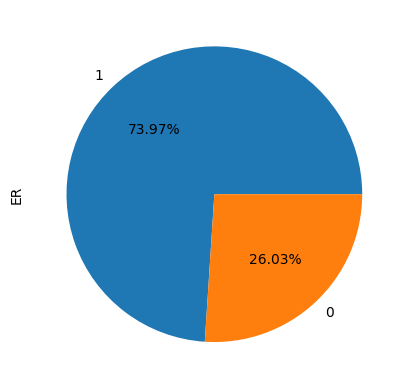

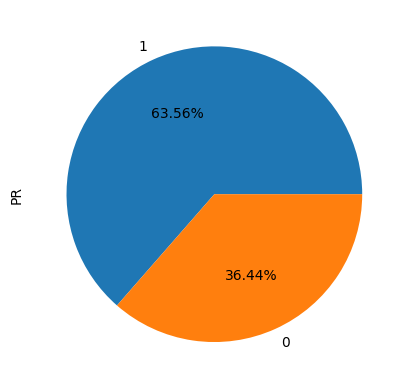

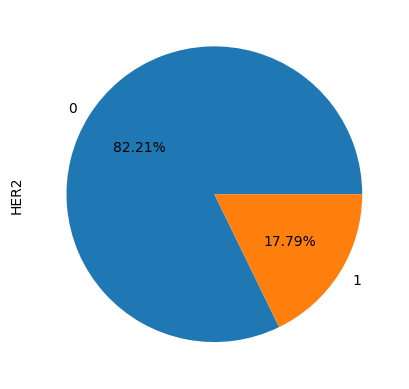

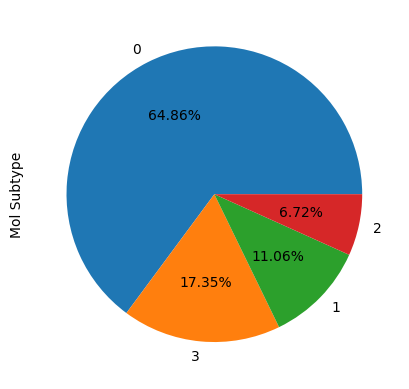

In [7]:
train_df['ER'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()
train_df['PR'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()
train_df['HER2'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()
train_df['Mol Subtype'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()

In [12]:
# print("Train:", len(train_x_er), ", Val:", len(val_x_er), ", Test:", len(test_x_er))
# dist = pd.DataFrame({'ER+': [train_y_er.value_counts()[0], val_y_er.value_counts()[0], test_y_er.value_counts()[0]],
#                      'ER-': [train_y_er.value_counts()[1], val_y_er.value_counts()[1], test_y_er.value_counts()[1]],
#                      'PR+': [train_y_pr.value_counts()[0], val_y_pr.value_counts()[0], test_y_pr.value_counts()[0]],
#                      'PR-': [train_y_pr.value_counts()[1], val_y_pr.value_counts()[1], test_y_pr.value_counts()[1]],
#                      'HER2+': [train_y_her2.value_counts()[0], val_y_her2.value_counts()[0], test_y_her2.value_counts()[0]],
#                      'HER2-': [train_y_her2.value_counts()[1], val_y_her2.value_counts()[1], test_y_her2.value_counts()[1]],
#                      'Mol Subtype (0)': [train_y_mol_subtype.value_counts()[0], val_y_mol_subtype.value_counts()[0], test_y_mol_subtype.value_counts()[0]],
#                      'Mol Subtype (1)': [train_y_mol_subtype.value_counts()[1], val_y_mol_subtype.value_counts()[1], test_y_mol_subtype.value_counts()[1]],
#                      'Mol Subtype (2)': [train_y_mol_subtype.value_counts()[2], val_y_mol_subtype.value_counts()[2], test_y_mol_subtype.value_counts()[2]],
#                      'Mol Subtype (3)': [train_y_mol_subtype.value_counts()[3], val_y_mol_subtype.value_counts()[3], test_y_mol_subtype.value_counts()[3]]},
#                      index = ['Train', 'Val', 'Test'])
# dist

In [ ]:
# # creating multiple subplots of graph to visualise the above data 
# fig, axes = plt.subplots(4, 3, figsize=(20, 15))
# plot_data = [[train_y_er, val_y_er, test_y_er], [train_y_pr, val_y_pr, test_y_pr], [train_y_her2, val_y_her2, test_y_her2], [train_y_mol_subtype, val_y_mol_subtype, test_y_mol_subtype]]
# for i in range(4):
#     for j in range(3):
#         sns.countplot(x=plot_data[i][j], ax=axes[i][j])
#         if i == 0:
#             axes[i][j].set_xlabel('ER Status')
#             if j == 0:
#                 axes[i][j].set_title('Training Data: ER Distribution (0 = Negative, 1 = Positive)')
#             elif j == 1:
#                 axes[i][j].set_title('Validation Data: ER Distribution (0 = Negative, 1 = Positive)')
#             else:
#                 axes[i][j].set_title('Testing Data: ER Distribution (0 = Negative, 1 = Positive)')
        
#         elif i == 1:
#             axes[i][j].set_xlabel('PR Status')
#             if j == 0:
#                 axes[i][j].set_title('Training Data: PR Distribution (0 = Negative, 1 = Positive)')
#             elif j == 1:
#                 axes[i][j].set_title('Validation Data: PR Distribution (0 = Negative, 1 = Positive)')
#             else:
#                 axes[i][j].set_title('Testing Data: PR Distribution (0 = Negative, 1 = Positive)')
        
#         elif i == 2:
#             axes[i][j].set_xlabel('HER2 Status')
#             if j == 0:
#                 axes[i][j].set_title('Training Data: HER2 Distribution (0 = Negative, 1 = Positive)')
#             elif j == 1:
#                 axes[i][j].set_title('Validation Data: HER2 Distribution (0 = Negative, 1 = Positive)')
#             else:
#                 axes[i][j].set_title('Testing Data: HER2 Distribution (0 = Negative, 1 = Positive)')
        
#         else:
#             axes[i][j].set_xlabel('Molecular Subtype')
#             if j == 0:
#                 axes[i][j].set_title('Training Data: Molecular Subtype Distribution')
#             elif j == 1:
#                 axes[i][j].set_title('Validation Data: Molecular Subtype Distribution')
#             else:
#                 axes[i][j].set_title('Testing Data: Molecular Subtype Distribution')

#         axes[i][j].set_ylabel('Count')

# plt.tight_layout()
# plt.show()

### Resampling for Training Samples

In [19]:
# Resampling the training data to balance the dataset using SMOTE

from imblearn.over_sampling import SMOTE
SEED = 2454259
def resample_data_smote(x, y):
    sm = SMOTE(random_state = SEED)
    x_res, y_res = sm.fit_resample(x, y)
    return x_res, y_res

train_x_er_sam, train_y_er_sam = resample_data_smote(train_x_er, train_y_er)
# train_x_pr_sam, train_y_pr_sam = resample_data_smote(train_x_pr, train_y_pr)
train_x_her2_sam, train_y_her2_sam = resample_data_smote(train_x_her2, train_y_her2)
# train_x_mol_subtype_sam, train_y_mol_subtype_sam = resample_data_smote(train_x_mol_subtype, train_y_mol_subtype)

In [20]:
train_x_er_sam.shape, train_y_er_sam.shape, train_x_her2_sam.shape, train_y_her2_sam.shape

((960, 107), (960,), (1062, 107), (1062,))

In [21]:
train_x_er = train_x_er_sam.copy()
train_y_er = train_y_er_sam.copy()

# # train_x_pr = train_x_pr_sam.copy()
# # train_y_pr = train_y_pr_sam.copy()

train_x_her2 = train_x_her2_sam.copy()
train_y_her2 = train_y_her2_sam.copy()

# # train_x_mol_subtype = train_x_mol_subtype_sam.copy()
# # train_y_mol_subtype = train_y_mol_subtype_sam.copy()

# print(train_x_er.shape, train_y_er.shape)
# print(train_x_pr.shape, train_y_pr.shape)
# print(train_x_her2.shape, train_y_her2.shape)
# print(train_x_mol_subtype.shape, train_y_mol_subtype.shape)

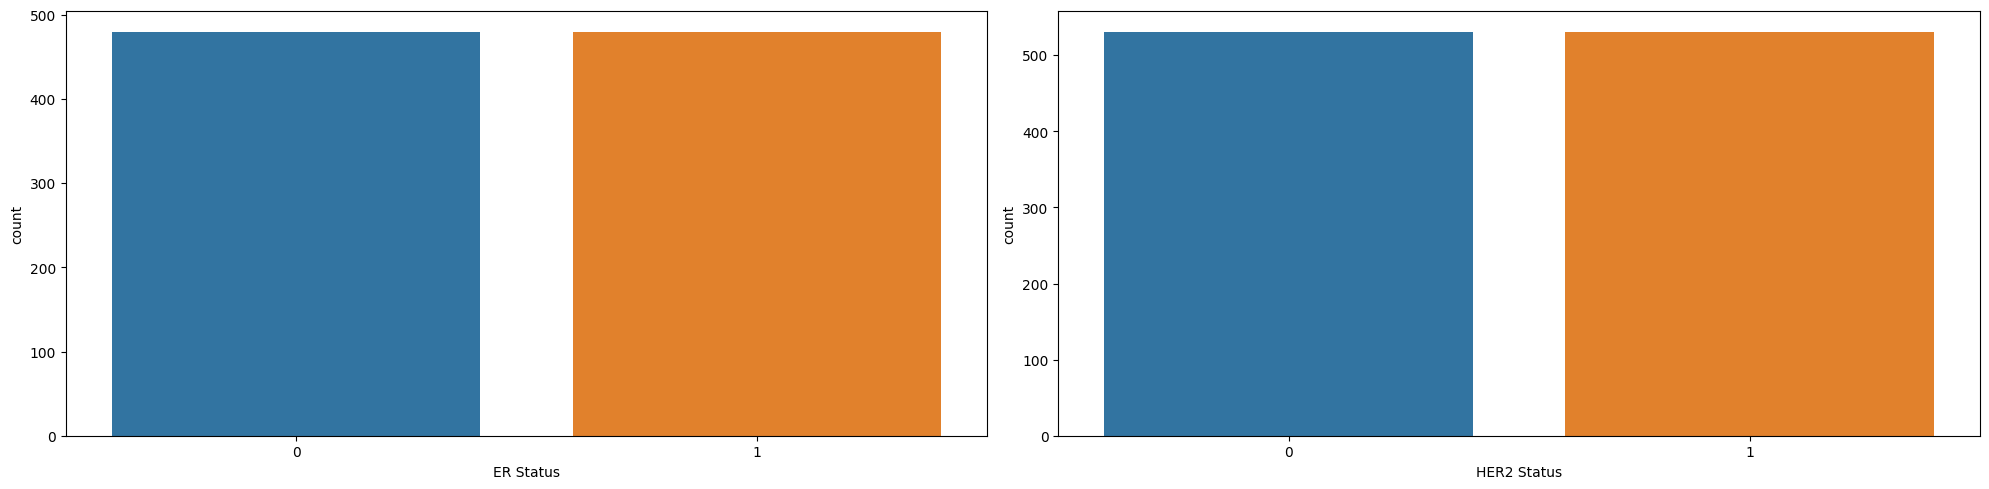

In [22]:
# Plotting the distribution of the resampled data

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(x=train_y_er, ax=axes[0])
axes[0].set_xlabel('ER Status')

sns.countplot(x=train_y_her2, ax=axes[1])
axes[1].set_xlabel('HER2 Status')

plt.tight_layout()
plt.show()

## Fitting models

In [11]:
classifications_classes = {
    'ER' : (train_x_er, train_y_er, val_x_er, val_y_er, test_x_er, test_y_er),
    'PR' : (train_x_pr, train_y_pr, val_x_pr, val_y_pr, test_x_pr, test_y_pr),
    'HER2': (train_x_her2, train_y_her2, val_x_her2, val_y_her2, test_x_her2, test_y_her2),
    'Mol Subtype': (train_x_mol_subtype, train_y_mol_subtype, val_x_mol_subtype, val_y_mol_subtype, test_x_mol_subtype, test_y_mol_subtype)
}

In [23]:
classifications_classes = {
    'ER' : (train_x_er, train_y_er, test_x_er, test_y_er),
    'PR' : (train_x_pr, train_y_pr, test_x_pr, test_y_pr),
    'HER2': (train_x_her2, train_y_her2, test_x_her2, test_y_her2),
    'Mol Subtype': (train_x_mol_subtype, train_y_mol_subtype, test_x_mol_subtype, test_y_mol_subtype)
}

In [24]:
def get_metrics(model, x, truey, split):
    pred_y = model.predict(x)
    acc = accuracy_score(truey, pred_y)
    prec = precision_score(truey, pred_y, average = 'weighted')
    rec = recall_score(truey, pred_y, average = 'weighted')
    f1 = f1_score(truey, pred_y, average = 'weighted')

    return {f'{split}_acc': acc, f'{split}_prec': prec, f'{split}_rec': rec, f'{split}_f1': f1}


In [44]:
def get_NB_model(tx, ty, testx, testy, classification = None):
    nb = GaussianNB()
    nb.fit(tx, ty)
    
    train_metrics = get_metrics(nb, tx, ty, 'train')
    # val_metrics = get_metrics(nb, vx, vy, 'val')
    test_metrics = get_metrics(nb, testx, testy, 'test')

    combined_metrics = {**train_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Naive Bayes'
    if classification is not None:
        result['classification'] = classification

    return result, nb

def get_DT_model(tx, ty, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Decision Tree model with metrics'''
    # model = decision_tree.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)
    model = decision_tree.DecisionTreeClassifier(criterion='entropy')
    model.fit(tx, ty)

    train_metrics = get_metrics(model, tx, ty, 'train')
    # val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Decision Tree'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_KNN_model(tx, ty, testx, testy, criterion = 'accuracy', classification = None):
    '''Get KNN model with metrics'''
    # model = k_nearest.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)
    model = k_nearest.KNeighborsClassifier(n_neighbors=7)
    model.fit(tx, ty)

    train_metrics = get_metrics(model, tx, ty, 'train')
    # val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'KNN'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_LR_model(tx, ty, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Logistic Regression model with metrics'''
    # model = logistic_regression.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)
    model = logistic_regression.LogisticRegression(solver='sag', C=100, max_iter=1000)
    model.fit(tx, ty)

    train_metrics = get_metrics(model, tx, ty, 'train')
    # val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Logistic Regression'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_RF_model(tx, ty, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Random forest model with metrics'''
    # model = random_forest.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)
    model = random_forest.RandomForestClassifier(n_estimators=100, max_depth=15)
    model.fit(tx, ty)

    train_metrics = get_metrics(model, tx, ty, 'train')
    # val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Random Forest'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_SVM_model(tx, ty, testx, testy, criterion = 'accuracy', classification = None):
    '''Get SVM model with metrics'''
    # model = support_vector_cls.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)
    model = support_vector_cls.SVC(C=100, kernel='rbf', gamma=0.001)
    model.fit(tx, ty)

    train_metrics = get_metrics(model, tx, ty, 'train')
    # val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'SVM'
    if classification is not None:
        result['classification'] = classification

    return result, model
    
def get_XGB_model(tx, ty, testx, testy, criterion = 'accuracy', classification = None):
    '''Get XGBoost model with metrics'''
    # model = xgboost.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)
    model = xgboost.XGBClassifier(learning_rate=0.1, max_depth=15, n_estimators=100)
    model.fit(tx, ty)

    train_metrics = get_metrics(model, tx, ty, 'train')
    # val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **train_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'XGBoost'
    if classification is not None:
        result['classification'] = classification

    return result, model

# def get_catboost_model(df, test_size=0.2, if_pca=True, n_components=10):
#     X_train, X_test, y_train, y_test = get_train_test_data(df, if_pca, n_components, test_size)
#     model_train_scores = dict()
#     model_test_scores = dict()

#     # CATBoost

#     model = CatBoostClassifier(verbose=100, max_depth = 3)
#     model.fit(X_train, y_train)
#     model_train_scores['CATBoost'] = model.score(X_train, y_train)
#     model_test_scores['CATBoost'] = model.score(X_test, y_test)

#     print('CATBoost')
#     print('Train Score:', model_train_scores['CATBoost'])
#     print('Test Score:', model_test_scores['CATBoost'])
#     print('Confusion Matrix:\n', confusion_matrix(y_test, model.predict(X_test)))
#     print('Classification Report:\n', classification_report(y_test, model.predict(X_test)))
#     print('--------------------------------------------------\n')

#     return model_train_scores, model_test_scores, model

# model_train_scores, model_test_scores, model = catboost(preprocessed_df, test_size=0.2, if_pca=True, n_components=10)

Earlier the results were so good because inadvertently we were scaling some of the labels too. Basically in the er, pr, etc classification tasks, the features dataset had all those labels except the label that it was going to predict. This was done because these labels were correlated. Now, we performed scaling at the time of running the models which meant that we overlooked the fact that the labels from other classes too were being scaled. This resulted in a good dataset which lead to higher accuracies (95+ %).

In [45]:
classification_results = pd.DataFrame()
models = {}


from sklearn.decomposition import PCA

for key, value in classifications_classes.items():

   tx, ty, testx, testy = value
    
   # Applying Feature Scaling to the data using the Standard Scaler
   scaler = Scaler()
   scaler.fit(tx)
   tx = scaler.transform(tx)
   # vx = scaler.transform(vx)
   testx = scaler.transform(testx)


   # Applying Principal Component Analysis to the data

   pca = PCA(n_components = 'mle', svd_solver = 'full')
   tx = pca.fit_transform(tx)
   # vx = pca.transform(vx)
   testx = pca.transform(testx)

   
   res_nb, nb = get_NB_model(tx, ty, testx, testy, classification = key)
   res_dt, dt = get_DT_model(tx, ty, testx, testy, criterion = CRITERION, classification = key)
   res_knn, knn = get_KNN_model(tx, ty, testx, testy, criterion = CRITERION, classification = key)
   res_lr, lr = get_LR_model(tx, ty, testx, testy, criterion = CRITERION, classification = key)
   res_rf, rf = get_RF_model(tx, ty, testx, testy, criterion = CRITERION, classification = key)
   res_svm, svm = get_SVM_model(tx, ty, testx, testy, criterion = CRITERION, classification = key)
   res_xgb, xgb = get_XGB_model(tx, ty, testx, testy, criterion = CRITERION, classification = key)

   models[key] = {'Naive Bayes' : nb,
                  'Decision Trees' : dt,
                  'K Nearest Neighbours': knn,
                  'Logistic Regression' : lr,
                  'Random Forest' : rf,
                  'SVM': svm,
                  'XGBoost': xgb}

   classification_results = pd.concat([classification_results,
                                       res_nb,
                                       res_dt,
                                       res_knn,
                                       res_lr,
                                       res_rf,
                                       res_svm,
                                       res_xgb]) 

c:\Users\MOHD SUFYAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\MOHD SUFYAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\MOHD SUFYAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\MOHD SUFYAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\MOHD SUFYAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: 

In [46]:
classification_results

,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1,Algorithm,classification
0,0.572917,0.598324,0.572917,0.543421,0.458484,0.637236,0.458484,0.483586,Naive Bayes,ER
0,1.000000,1.000000,1.000000,1.000000,0.595668,0.636739,0.595668,0.612392,Decision Tree,ER
0,0.771875,0.782479,0.771875,0.769714,0.592058,0.686295,0.592058,0.617580,KNN,ER
0,0.654167,0.654298,0.654167,0.654093,0.613718,0.681911,0.613718,0.635646,Logistic Regression,ER
0,1.000000,1.000000,1.000000,1.000000,0.711191,0.670393,0.711191,0.682313,Random Forest,ER
0,0.616667,0.617188,0.616667,0.616240,0.617329,0.694063,0.617329,0.640097,SVM,ER
0,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,XGBoost,ER
0,0.648062,0.616554,0.648062,0.610703,0.606498,0.566863,0.606498,0.573891,Naive Bayes,PR
0,1.000000,1.000000,1.000000,1.000000,0.523466,0.525716,0.523466,0.524566,Decision Tree,PR
0,0.691473,0.675693,0.691473,0.665596,0.592058,0.545740,0.592058,0.555737,KNN,PR


In [15]:
classification_results

,train_acc,train_prec,train_rec,train_f1,val_acc,val_prec,val_rec,val_f1,test_acc,test_prec,test_rec,test_f1,Algorithm,classification
0,0.700880,0.729272,0.700880,0.691323,0.592391,0.689939,0.592391,0.616000,0.595668,0.739166,0.595668,0.624168,Naive Bayes,ER
0,0.950147,0.951404,0.950147,0.950112,0.951087,0.950834,0.951087,0.950925,0.945848,0.947915,0.945848,0.946496,Decision Tree,ER
0,0.963343,0.963443,0.963343,0.963341,0.956522,0.957342,0.956522,0.956794,0.956679,0.958025,0.956679,0.957098,KNN,ER
0,0.975073,0.976257,0.975073,0.975058,0.983696,0.984050,0.983696,0.983528,0.985560,0.985560,0.985560,0.985560,Logistic Regression,ER
0,0.988270,0.988539,0.988270,0.988268,0.983696,0.984050,0.983696,0.983528,0.953069,0.952629,0.953069,0.952698,Random Forest,ER
0,0.972141,0.973611,0.972141,0.972119,0.983696,0.984050,0.983696,0.983528,0.992780,0.992848,0.992780,0.992742,SVM,ER
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,XGBoost,ER
0,0.702820,0.692832,0.702820,0.683869,0.722826,0.710522,0.722826,0.709834,0.711191,0.696561,0.711191,0.686390,Naive Bayes,PR
0,0.882863,0.890365,0.882863,0.878691,0.923913,0.926763,0.923913,0.922074,0.844765,0.843100,0.844765,0.841091,Decision Tree,PR
0,0.867679,0.880961,0.867679,0.861137,0.913043,0.919850,0.913043,0.909869,0.895307,0.906848,0.895307,0.890125,KNN,PR


In [19]:
classification_results.to_csv("W_scaling_W_PCA_W_resampling_Wo_labels_as_features.csv", index = False)

In [22]:
models

{'ER': {'Naive Bayes': GaussianNB(),
  'Decision Trees': DecisionTreeClassifier(criterion='entropy', min_samples_split=16),
  'K Nearest Neighbours': KNeighborsClassifier(n_neighbors=11),
  'Logistic Regression': LogisticRegression(C=100, solver='sag'),
  'Random Forest': RandomForestClassifier(max_depth=15, n_estimators=200),
  'SVM': SVC(C=0.1, gamma=0.001),
  'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=10,
                min_child_weight=None, missing=nan, monotone_co

In [ ]:
# importing zgboost
import xgboost as xgb
from xgboost import XGBClassifier


'''
{'ER': {'Naive Bayes': GaussianNB(),
  'Decision Trees': DecisionTreeClassifier(criterion='entropy', min_samples_split=16),
  'K Nearest Neighbours': KNeighborsClassifier(n_neighbors=11),
  'Logistic Regression': LogisticRegression(C=100, solver='sag'),
  'Random Forest': RandomForestClassifier(max_depth=15, n_estimators=200),
  'SVM': SVC(C=0.1, gamma=0.001),
  'XGBoost': XGBClassifier(max_depth=5, max_leaves=10, n_estimators=30)},
 'PR': {'Naive Bayes': GaussianNB(),
  'Decision Trees': DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=8),
  'K Nearest Neighbours': KNeighborsClassifier(n_neighbors=3),
  'Logistic Regression': LogisticRegression(C=100, solver='sag'),
  'Random Forest': RandomForestClassifier(max_depth=6, n_estimators=60),
  'SVM': SVC(C=100, gamma=0.1),
  'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=20,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=30, n_jobs=None,
                num_parallel_tree=None, random_state=None, ...)},
 'HER2': {'Naive Bayes': GaussianNB(),
  'Decision Trees': DecisionTreeClassifier(criterion='entropy', max_depth=20),
  'K Nearest Neighbours': KNeighborsClassifier(n_neighbors=3),
  'Logistic Regression': LogisticRegression(C=100, solver='sag'),
  'Random Forest': RandomForestClassifier(max_depth=15, n_estimators=20),
  'SVM': SVC(C=0.1, gamma=10),
  'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=20,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=30, n_jobs=None,
                num_parallel_tree=None, random_state=None, ...)},
 'Mol Subtype': {'Naive Bayes': GaussianNB(),
  'Decision Trees': DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=4),
  'K Nearest Neighbours': KNeighborsClassifier(n_neighbors=11),
  'Logistic Regression': LogisticRegression(C=10, solver='liblinear'),
  'Random Forest': RandomForestClassifier(max_depth=15, n_estimators=40),
  'SVM': SVC(C=0.1, gamma='auto', kernel='poly'),
  'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=10,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=10, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob', ...)}}
'''

In [ ]:
# RESULTS_PATH = f'Results_NoResample/55_15_30_Scaling_PCA_{FILENAME}.csv'

# MODEL_PICKLING = f'Results_NoResample/55_15_30_Models_Scaling_PCA_{FILENAME}.pkl'

cols = classification_results.columns.tolist()
cols = cols[-2:] + cols[:-2]
classification_results = classification_results[cols]

classification_results.to_csv(RESULTS_PATH, index = False)

with open(MODEL_PICKLING, 'wb') as file:
    pkl.dump(models, file)